In [1]:
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

import shutil
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re
import spacy
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from scipy import sparse

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Exploration des données

In [2]:
data = pd.read_csv('/kaggle/input/stackoverflowwdate/QueryResults.csv')
data.head()

,Id,Title,Body,Tags,Score,ViewCount,AnswerCount,CreationDate
0,75956209,"Error ""'DataFrame' object has no attribute 'ap...",<p>I am trying to append a dictionary to a Dat...,<python><pandas><dataframe><concatenation><att...,312,692073,3,2023-04-07 07:05:59
1,75898276,"OpenAI API error 429: ""You exceeded your curre...",<p>I'm making a Python script to use OpenAI vi...,<python><prompt><openai-api><completion><chatg...,169,416362,5,2023-03-31 11:58:04
2,77171270,Compilation error after upgrading to JDK 21 - ...,"<p>After upgrading to JDK 21, I have the follo...",<spring-boot><compiler-errors><upgrade><lombok...,358,396585,13,2023-09-25 09:05:11
3,76435306,"babel-preset-react-app, is importing the ""@bab...",<p>My issue is that I've tried to create a new...,<javascript><node.js><reactjs><babeljs><ejs>,155,273911,24,2023-06-08 19:56:44
4,76303988,"""ERROR: File xxx can't be indexed twice."" when...",<p>Below is my Azure pipeline to analyze a sol...,<c#><c++><sonarqube><sonarqube-scan><sonar-run...,0,208657,1,2023-05-22 07:45:00


In [3]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [4]:
def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Supprimer HTML
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())  # Supprimer ponctuation et mettre en minuscule
    tokens = gensim.utils.simple_preprocess(text, deacc=True)  # Tokenization (Gensim)
    tokens = [word for word in tokens if word not in STOPWORDS]  # Supprimer stopwords
    tokens = [token.lemma_ for token in nlp(" ".join(tokens)) if token.pos_ in ["NOUN", "VERB"]]  # Lemmatisation
    return tokens

In [5]:
data["Processed"] = (data["Title"] + " " + data["Body"]).apply(preprocess_text)
display(data["Processed"])

0        [error, object, attribute, append, try, append...
1        [api, error, exceed, quota, check, plan, billi...
2        [compilation, error, upgrade, upgrade, follow,...
3        [react, app, import, babel, plugin, proposal, ...
4        [error, file, index, analyze, solution, mix, a...
                               ...                        
49995    [laravel, foreach, error, ve, swagger, laravel...
49996    [homebrew, error, instal, ghc, linker, option,...
49997    [environment, set, hostname, ip, adress, conne...
49998    [totalpurchaser, analytic, give, result, custo...
49999    [tls, certificate, verification, implement, ce...
Name: Processed, Length: 50000, dtype: object

In [6]:
data.to_csv("preprocessed_data.csv", index=False)

In [7]:
# Séparer le dataset en Train (80%) et Test (20%)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Vérifier la taille des jeux de données
print(f"Taille du train : {len(train_data)}")
print(f"Taille du test : {len(test_data)}")

Taille du train : 40000
Taille du test : 10000


In [8]:
train_data["Processed"] = train_data["Processed"].apply(lambda x: " ".join(x))
test_data["Processed"] = test_data["Processed"].apply(lambda x: " ".join(x))

# Vectorisation uniquement sur Train
vectorizer = CountVectorizer(min_df=5, stop_words='english')
X_train_count = vectorizer.fit_transform(train_data["Processed"])  # Fit sur Train
X_test_count = vectorizer.transform(test_data["Processed"])  # Transform sur Test

In [9]:
# Créer le dictionnaire Gensim
dictionary = corpora.Dictionary(train_data["Processed"].apply(str.split))

In [10]:
# Conversion en BoW
corpus_train = [dictionary.doc2bow(text.split()) for text in train_data["Processed"]]
corpus_test = [dictionary.doc2bow(text.split()) for text in test_data["Processed"]]

# Vérifier un document
print(corpus_train[0])  # Bag-of-Words pour le premier document

[(0, 1), (1, 3), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 6), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 4), (20, 1), (21, 3), (22, 1), (23, 7), (24, 2)]


Num Topics = 5, Coherence Score = 0.5149211279297192
Num Topics = 6, Coherence Score = 0.5144632146858307
Num Topics = 7, Coherence Score = 0.49694738310815195
Num Topics = 8, Coherence Score = 0.5430456127231849
Num Topics = 9, Coherence Score = 0.5670641193765311
Num Topics = 10, Coherence Score = 0.5496412431930787
Num Topics = 11, Coherence Score = 0.5504283879701514
Num Topics = 12, Coherence Score = 0.569818883956546
Num Topics = 13, Coherence Score = 0.5522441996213358
Num Topics = 14, Coherence Score = 0.5567471402641576
Num Topics = 15, Coherence Score = 0.564114238229521
Num Topics = 16, Coherence Score = 0.5811005662442441
Num Topics = 17, Coherence Score = 0.5538594247417634
Num Topics = 18, Coherence Score = 0.5645855978140522
Num Topics = 19, Coherence Score = 0.5526574074229782


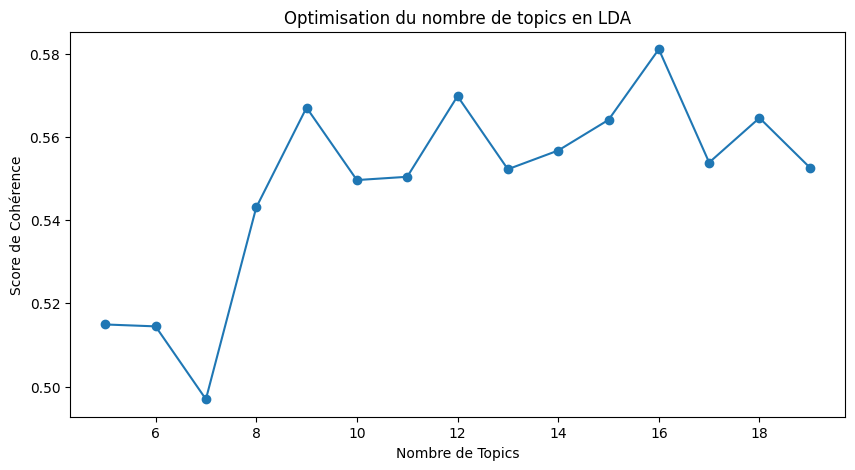

Nombre optimal de topics : 16


In [11]:
def compute_coherence_values(dictionary, corpus, texts, start=5, limit=10, step=1):
    coherence_values = []
    topic_list = []

    for num_topics in range(start, limit, step):
        # Entraîner le modèle LDA avec un nombre de topics donné
        lda_model = LdaModel(
            corpus=corpus, id2word=dictionary, num_topics=num_topics,
            passes=5, chunksize=500, random_state=42
        )

        # Calculer le score de cohérence
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()

        # Sauvegarder les résultats
        coherence_values.append(coherence_score)
        topic_list.append(num_topics)

        print(f"Num Topics = {num_topics}, Coherence Score = {coherence_score}")

    return topic_list, coherence_values

texts = train_data["Processed"].apply(str.split).tolist()  # Convertit en liste de tokens

# Appliquer la fonction pour tester plusieurs valeurs de `num_topics`
topic_list, coherence_values = compute_coherence_values(dictionary, corpus_train, texts, start=5, limit=20, step=1)

# Tracer l'évolution du `coherence score`
plt.figure(figsize=(10, 5))
plt.plot(topic_list, coherence_values, marker='o', linestyle='-')
plt.xlabel("Nombre de Topics")
plt.ylabel("Score de Cohérence")
plt.title("Optimisation du nombre de topics en LDA")
plt.show()

# Trouver le nombre optimal de topics
optimal_topics = topic_list[coherence_values.index(max(coherence_values))]
print(f"Nombre optimal de topics : {optimal_topics}")

In [12]:
lda_model = LdaModel(
    corpus=corpus_train,
    id2word=dictionary,
    num_topics=optimal_topics,
    passes=10,       # Nombre de passes sur les données
    chunksize=200,   # Charge les documents par batchs pour économiser de la RAM
    alpha='auto',    # Ajuste automatiquement le paramètre alpha
    eta='auto',      # Ajuste automatiquement le paramètre eta
    random_state=42
)

In [13]:
lda_vis = gensimvis.prepare(lda_model, corpus_train, dictionary)
pyLDAvis.save_html(lda_vis, "lda_visualisation.html")
print("Visualisation enregistrée : ouvre 'lda_visualisation.html' pour voir les topics")

Visualisation enregistrée : ouvre 'lda_visualisation.html' pour voir les topics


In [14]:
from IPython.display import FileLink

# Créer un lien de téléchargement
FileLink("lda_visualisation.html")

/kaggle/working/lda_visualisation.html

In [15]:
lda_model.print_topics(num_words=5)

[(0,
  '0.104*"view" + 0.098*"context" + 0.085*"state" + 0.049*"let" + 0.027*"var"'),
 (1,
  '0.273*"user" + 0.062*"line" + 0.056*"package" + 0.054*"site" + 0.035*"permission"'),
 (2,
  '0.073*"model" + 0.068*"self" + 0.037*"import" + 0.031*"datum" + 0.023*"print"'),
 (3,
  '0.083*"com" + 0.059*"flutter" + 0.057*"gradle" + 0.049*"android" + 0.044*"androidx"'),
 (4,
  '0.045*"date" + 0.044*"message" + 0.043*"time" + 0.040*"log" + 0.035*"event"'),
 (5,
  '0.036*"error" + 0.034*"request" + 0.032*"server" + 0.029*"api" + 0.024*"response"'),
 (6,
  '0.145*"image" + 0.066*"container" + 0.050*"docker" + 0.044*"group" + 0.037*"deploy"'),
 (7,
  '0.083*"text" + 0.054*"item" + 0.040*"class" + 0.038*"color" + 0.036*"style"'),
 (8,
  '0.097*"table" + 0.070*"column" + 0.065*"database" + 0.041*"query" + 0.040*"row"'),
 (9,
  '0.095*"import" + 0.063*"react" + 0.056*"const" + 0.050*"component" + 0.041*"page"'),
 (10,
  '0.090*"index" + 0.089*"order" + 0.078*"number" + 0.061*"document" + 0.061*"filter"

In [16]:
def get_keywords_for_test(lda_model, topics_test, dictionary, num_words=5):
    """
    Associe les mots-clés des topics aux documents test.
    """
    keywords_per_doc = []
    
    for row in topics_test:
        if row:
            topic_idx = max(row, key=lambda x: x[1])[0]  # Prendre le topic dominant
            topic_words = lda_model.show_topic(topic_idx, num_words)
            keywords = [word for word, _ in topic_words]
        else:
            keywords = []
        
        keywords_per_doc.append(keywords)
    
    return keywords_per_doc

topics_test = [lda_model.get_document_topics(bow) for bow in corpus_test]

# Associer des mots-clés aux documents test
test_data["Keywords"] = get_keywords_for_test(lda_model, topics_test, dictionary)

# Afficher quelques résultats
for i in range(10):
    print(f"Question : {test_data.iloc[i]['Title']}")
    print(f"Mots-clés suggérés : {test_data.iloc[i]['Keywords']}")
    print("-" * 80)

Question : How do I pass in parameters into arrow functions in react?
Mots-clés suggérés : ['try', 'work', 'code', 'use', 'function']
--------------------------------------------------------------------------------
Question : How to test @NotBlank spring validation with JUnit?
Mots-clés suggérés : ['string', 'type', 'class', 'return', 'value']
--------------------------------------------------------------------------------
Question : DBeaver - unable to update driver: "Network unavailable due to certificate issue."
Mots-clés suggérés : ['try', 'work', 'code', 'use', 'function']
--------------------------------------------------------------------------------
Question : Youtube player API to get server url few times returning error while works if I reload again
Mots-clés suggérés : ['error', 'request', 'server', 'api', 'response']
--------------------------------------------------------------------------------
Question : Where is it specified the path to look for kernel.json, to select t